In [1]:
library(tidyverse)

library(grid)
library(gridExtra)

source("/home/yuliya/repos/other/removeBatch/evaluation_utils/plots_eda.R")

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Warning message:
“package ‘umap’ was built under R version 4.3.3”
Warning message:
“package ‘ggsci’ was built under R version 4.3.3”
Loading required package: viridisLite



In [2]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

# Load data

In [3]:
data_path <- "../evaluation_data/microarray/"


central_corrected <- read.csv(paste0(data_path, "after/central_corrected_UNION.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
central_uncorrected <- read.csv(paste0(data_path, "before/all_expression_UNION.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
metadata <- read.csv(paste0(data_path, "before/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

# remove X from row names
rownames(metadata) <- gsub("X", "", rownames(metadata))
metadata$file <- rownames(metadata)
# order the columns in intensity dataframes
central_corrected <- central_corrected[, rownames(metadata)]
central_uncorrected <- central_uncorrected[, rownames(metadata)]

cat("Loaded data")
cat("Central corrected:", nrow(central_corrected), "rows\n")
cat("Central uncorrected:", nrow(central_uncorrected), "rows\n")
cat("Sample metadata:", nrow(metadata), "rows\n\n")



Loaded dataCentral corrected: 51276 rows
Central uncorrected: 51276 rows
Sample metadata: 332 rows



# Checks

## Diagnostic plots

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


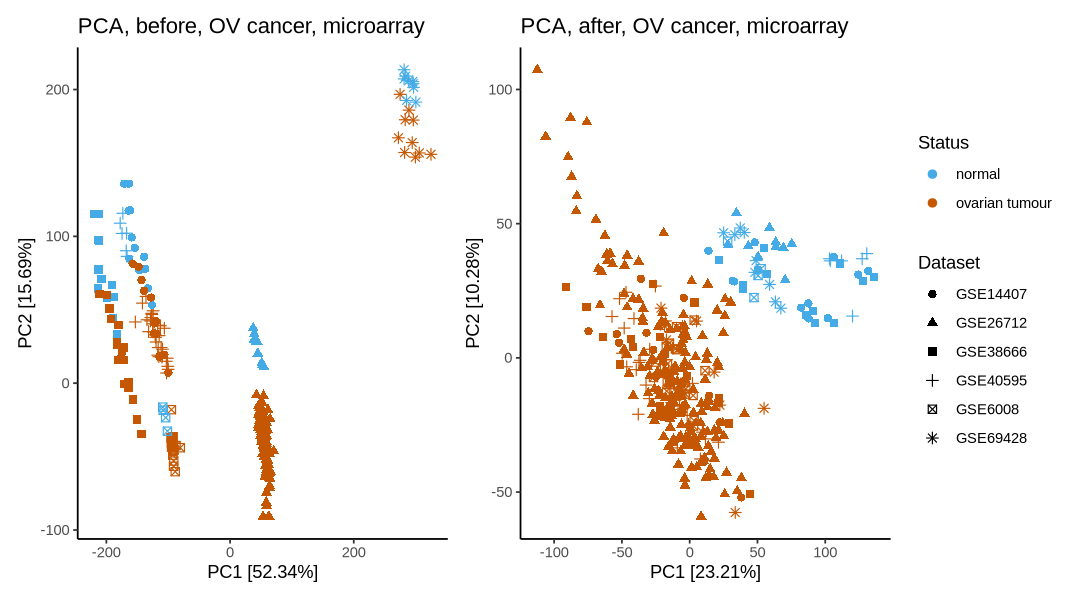

In [4]:
pca_plot_uncorrected <- pca_plot(central_uncorrected, metadata, 
    title = paste("PCA, before, OV cancer, microarray"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=F, cbPalette=c("#44abe7", "#c55702"))
pca_plot_corrected <- pca_plot(central_corrected, metadata, 
    title = paste("PCA, after, OV cancer, microarray"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=T, cbPalette=c("#44abe7", "#c55702"))

layout <- (pca_plot_uncorrected + pca_plot_corrected)

options(repr.plot.width=9, repr.plot.height=5)
layout

Warning message:
“Removed 927072 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 927072 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 927072 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 923742 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 923742 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 923742 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_violin()`).”


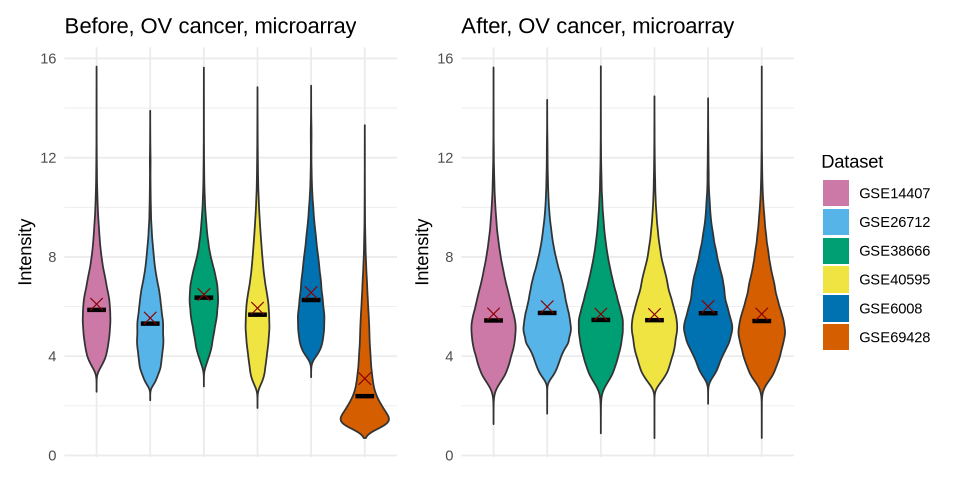

In [5]:
# sample 7000 rows for boxplots
sample_cor <- central_corrected[sample(1:nrow(central_corrected), 7000),]
sample_uncor <- central_uncorrected[sample(1:nrow(central_uncorrected), 7000),]

# # Determine the shared Y-axis limits
y_min <- min(sample_cor, sample_uncor, na.rm = TRUE)
y_max <- max(sample_cor, sample_uncor, na.rm = TRUE)
y_limits <- c(y_min, y_max)

boxplots_uncorrected <- boxplot_plot_groupped(sample_uncor, metadata,
    title = paste("Before, OV cancer, microarray"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
boxplots_corrected <- boxplot_plot_groupped(sample_cor, metadata, 
    title = paste("After, OV cancer, microarray"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, y_limits = y_limits, cbPalette = cbPalette)


options(repr.plot.width=8, repr.plot.height=4)
layout <- boxplots_uncorrected | boxplots_corrected
layout

Warning message:
“Removed 927072 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 927072 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 927072 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 923742 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 923742 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 923742 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_violin()`).”


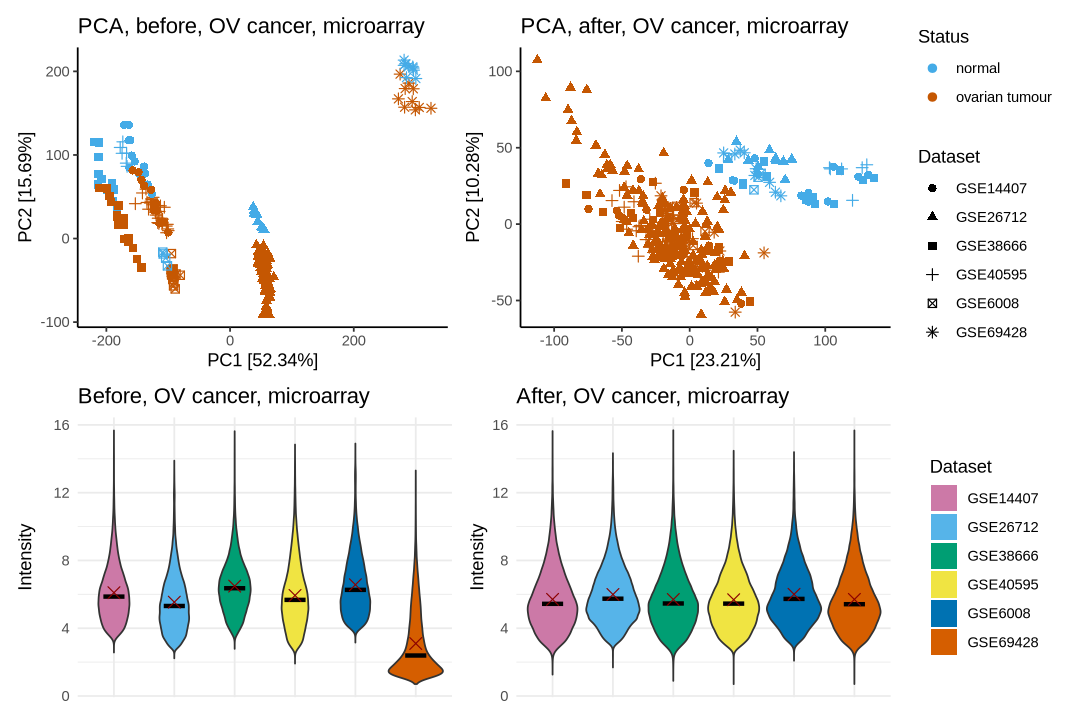

In [6]:
layout <- (pca_plot_uncorrected + pca_plot_corrected) / (boxplots_uncorrected | boxplots_corrected)

options(repr.plot.width=9, repr.plot.height=6)
layout

##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [7]:
library(variancePartition)

Loading required package: limma

Loading required package: BiocParallel




Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [8]:
lmpv_plot <- function(data, metadata, title, y_limits = c(0, 1), show_legend = T){
    form <- ~ Status + Dataset

    varPart <- fitExtractVarPartModel(na.omit(data), form, metadata)
    variance_col <- as.matrix(varPart[,1:2])

    df_long <- reshape2::melt(variance_col)

    # Plotting the boxplots using ggplot2
    res_plots <- ggplot(df_long, aes(x = Var2, y = value, fill=Var2)) +
      geom_boxplot() +
      labs(title = title,
           y = "Proportion Variance", x = "Column") +
          scale_fill_discrete(name = "Column") +
      theme_minimal() +
      ylim(y_limits)

  if(!show_legend){
    res_plots <- res_plots + 
    theme(legend.position = "none")
  }

  return(res_plots)
}

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack





Total:95 s


Total:87 s



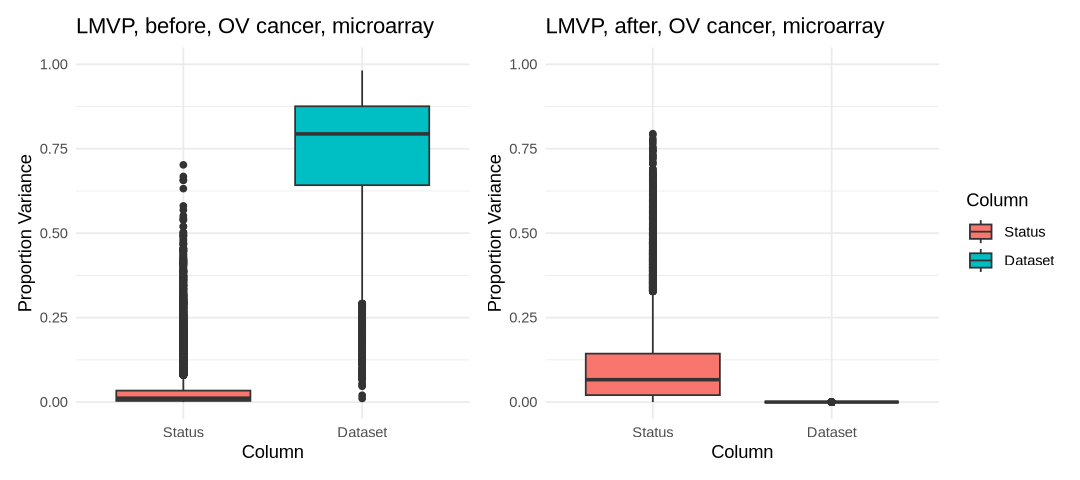

In [9]:
lmpv_plots_corrected <- lmpv_plot(central_corrected, metadata, 
    title = paste("LMVP, after, OV cancer, microarray"))
lmpv_plot_uncorrected <- lmpv_plot(central_uncorrected, metadata, 
    title = paste("LMVP, before, OV cancer, microarray"), show_legend=F)


layout <- (lmpv_plot_uncorrected + lmpv_plots_corrected) 
options(repr.plot.width=9, repr.plot.height=4)
layout